# Episodic Mountain Car with function appoximation and control

This Notebook is intended to solve the Episodic Mountain car problem using Semi-gradient sarsa and Tile Coding.

The description of the problem is given below:

"A car is on a one-dimensional track, positioned between two "mountains". The goal is to drive up the mountain on the right; however, the car's engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum." 

<img src="./assets/car.png" width="380" />

An extensive description and solution of the problem can be seen here [Section 10.1 Reinforment Learning an Introduction](http://www.incompleteideas.net/book/RLbook2018.pdf#page=267)

Image and Text taken from Taken from [Official documentaiton Mountain car](https://gymnasium.farama.org/environments/classic_control/mountain_car/).

Adapted from [MikeS96/rl_openai](https://github.com/MikeS96/rl_openai/blob/master/Mountain%20Car.ipynb)

In [ ]:
# Install required packages
# Run this cell first to ensure all dependencies are installed
# After running, RESTART THE KERNEL before running the next cell

%pip install --upgrade "numpy<2" "matplotlib>=3.7" gymnasium[classic-control] tqdm moviepy ipykernel

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import tiles3 as tc
from tqdm import tqdm

import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from utils import *

%matplotlib inline

## Undestanding the Workflow of OpenAI

The following variables are used at each timestep and they are returned by the Mountain Car environment. 


- **observation** (object): an environment-specific object representing your observation of the environment. For example, pixel data from a camera, joint angles and joint velocities of a robot, or the board state in a board game.
- **reward** (float): amount of reward achieved by the previous action. The scale varies between environments, but the goal is always to increase your total reward.
- **done** (boolean): whether it’s time to reset the environment again. Most (but not all) tasks are divided up into well-defined episodes, and done being True indicates the episode has terminated. (For example, perhaps the pole tipped too far, or you lost your last life.)
- **info** (dict): diagnostic information useful for debugging. It can sometimes be useful for learning (for example, it might contain the raw probabilities behind the environment’s last state change). However, official evaluations of your agent are not allowed to use this for learning.


As a quick recap, the diagram below explains the workflow of a Markov Decision Process (MDP)

<img src="./assets/MDP.png" width="380" />

Image taken from [Section 3.1 Reinforment Learning an Introduction](http://www.incompleteideas.net/book/RLbook2018.pdf#page=70)

## Environment and Agent specifications

Below are presented the main features of the environment and agent. Overall, the action space of the problem is discrete with three posible actions. The observations or state space is continuios, therefore it is necessary to use a function approximation technique to solve this challenge. The agent receives a reward of -1 at each timestep unless it reaches the goal. The episode ends if the agent reaches the goal or a specific number of iterations are done. Additionally, the agent will always start at a random position between $-0.6$ and $-0.4$ with zero velocity.

**Observation**: 

     Type:  Box(2)
     Num    Observation               Min            Max
     0      Car Position              -1.2           0.6
     1      Car Velocity              -0.07          0.07
         
**Actions**:

     Type: Discrete(3)
     Num    Action
     0      Accelerate to the Left
     1      Don't accelerate
     2      Accelerate to the Right

     Note: This does not affect the amount of velocity affected by the gravitational pull acting on the car
        
**Reward**:

     Reward of 0 is awarded if the agent reached the flag(position = 0.5) on top of the mountain
     Reward of -1 is awarded if the position of the agent is less than 0.5
        
**Starting State**:

     The position of the car is assigned a uniform random value in [-0.6 , -0.4]
     The velocity of the car is always assigned to 0
        
**Episode Termination**:

     The car position is more than 0.5
     Episode length is greater than 200
     
For further information see [Github source code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py)

The next cell aims to show how to iterate with the action and observation space of the agent and extract relevant information from it

In [3]:
env = gym.make("MountainCar-v0")
observation, info = env.reset() 

# Object's type in the action Space
print("The Action Space is an object of type: {0}\n".format(env.action_space))
# Shape of the action Space
print("The shape of the action space is: {0}\n".format(env.action_space.n))
# Object's type in the Observation Space
print("The Environment Space is an object of type: {0}\n".format(env.observation_space))
# Shape of the observation space
print("The Shape of the dimension Space are: {0}\n".format(env.observation_space.shape))
# The high and low values in the observation space
print("The High values in the observation space are {0}, the low values are {1}\n".format(
    env.observation_space.high, env.observation_space.low))
# Minimum and Maximum car position
print("The minimum and maximum car's position are: {0}, {1}\n".format(
    env.observation_space.low[0], env.observation_space.high[0]))
# Minimum and Maximum car velocity
print("The minimum and maximum car's velocity are: {0}, {1}\n".format(
    env.observation_space.low[1], env.observation_space.high[1]))
# Example of observation
print("The Observations at a given timestep are {0}\n".format(env.observation_space.sample()))

The Action Space is an object of type: Discrete(3)

The shape of the action space is: 3

The Environment Space is an object of type: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

The Shape of the dimension Space are: (2,)

The High values in the observation space are [0.6  0.07], the low values are [-1.2  -0.07]

The minimum and maximum car's position are: -1.2000000476837158, 0.6000000238418579

The minimum and maximum car's velocity are: -0.07000000029802322, 0.07000000029802322

The Observations at a given timestep are [-0.42506143  0.03326045]



# Tile Coding Class

For a complete explanation about what is tile coding and how it works, see [Section 9.5.4 of Reinforment Learning an Introduction](http://www.incompleteideas.net/book/RLbook2018.pdf#page=239). Overall, this is a way to create features that can both provide good generalization and discrimination for value function approximation. Tile coding consists of multiple overlapping tiling, where each tiling is a partitioning of the space into tiles.

<img src="./assets/tilecoding.png" width="640" />

**Note**: Tile coding can be only be used with 2d observation spaces.

This technique is implemented using Tiles3, which is a python library written by Richard S. Sutton. For the full documentation see [Tiles3 documentation](http://incompleteideas.net/tiles/tiles3.html)

Image taken from [Section 9.5.4 of Reinforment Learning an Introduction](http://www.incompleteideas.net/book/RLbook2018.pdf#page=239)

In [4]:
# Tile Coding Class
class MountainCarTileCoder:
    def __init__(self, iht_size=4096, num_tilings=8, num_tiles=8):
        """
        Initializes the MountainCar Tile Coder
        Initializers:
        iht_size -- int, the size of the index hash table, typically a power of 2
        num_tilings -- int, the number of tilings
        num_tiles -- int, the number of tiles. Here both the width and height of the
                     tile coder are the same
        Class Variables:
        self.iht -- tc.IHT, the index hash table that the tile coder will use
        self.num_tilings -- int, the number of tilings the tile coder will use
        self.num_tiles -- int, the number of tiles the tile coder will use
        """
        self.iht = tc.IHT(iht_size)
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
    
    def get_tiles(self, position, velocity):
        """
        Takes in a position and velocity from the mountaincar environment
        and returns a numpy array of active tiles.
        
        Arguments:
        position -- float, the position of the agent between -1.2 and 0.5
        velocity -- float, the velocity of the agent between -0.07 and 0.07
        returns:
        tiles - np.array, active tiles
        """
        # Set the max and min of position and velocity to scale the input
        # The max position is set to 0.5 as this is the position to end the experiment
        POSITION_MIN = -1.2
        POSITION_MAX = 0.5
        VELOCITY_MIN = -0.07
        VELOCITY_MAX = 0.07
        
        # Scale position and velocity by multiplying the inputs of each by their scale
        position_scale = self.num_tiles / (POSITION_MAX - POSITION_MIN)
        velocity_scale = self.num_tiles / (VELOCITY_MAX - VELOCITY_MIN)
        
        # Obtain active tiles for current position and velocity
        tiles = tc.tiles(self.iht, self.num_tilings, [position * position_scale, 
                                                      velocity * velocity_scale])
        
        return np.array(tiles)

In [5]:
# Test the TileCoder class
mctc = MountainCarTileCoder(iht_size = 1024, num_tilings = 8, num_tiles = 8)
tiles = mctc.get_tiles(position = -1.0, velocity = 0.01)
# Tiles obtained at a random pos and vel
print("The Tiles obtained are: {0}\n".format(tiles))

The Tiles obtained are: [0 1 2 3 4 5 6 7]



# Implementing Sarsa Agent

To solve the Mountain Car problem, Value Function approximation and control will be used (Owing to the continuous state space). As a quick recap, Action-values can be computed using value function approximation giving the following equation.

\begin{equation} 
q_\pi(s) \approx \hat{q}(s, a, w) \doteq w^T x(s,a)
\end{equation}

Where $w$ are a set of weights and $x(s,a)$ are the features vector which are computed using tile coding.

Using the Tile coder implemented above it is possible to compute the action-values $\hat{q}(s, a, w)$ and solve this RL task. 

The equation to update the weights using the Sarsa algorithm is given below. Here, $\nabla \hat{q}(S_t, A_t, w)$ is the gradient of the action-values approximation but as $x(s,a)$ is a linear function, the gradient is one only for the active features.

\begin{equation} 
w \leftarrow w + \alpha[R_{t+1} + \gamma \hat{q}(S_{t+1}, A_{t+1}, w)- \hat{q}(S_t, A_t, w)]\nabla \hat{q}(S_t, A_t, w)
\end{equation}

Additionally, the update "Target" is composed of the following terms:

\begin{equation} 
\delta \leftarrow R_{t+1} + \gamma \hat{q}(S_{t+1}, A_{t+1}, w)
\end{equation}

\begin{equation} 
w \leftarrow w + \alpha[\delta - \hat{q}(S_t, A_t, w)]\nabla \hat{q}(S_t, A_t, w)
\end{equation}

The Pseudo-code implementation of this algorithm is given below.

<img src="./assets/pseudocode.png" width="480" />


For further details, see [Section 9.5.4 of Reinforment Learning an Introduction](http://www.incompleteideas.net/book/RLbook2018.pdf#page=266). Image taken from the last reference.

In [6]:
# SARSA
class SarsaAgent():
    """
    Initialization of Sarsa Agent. All values are set to None so they can
    be initialized in the agent_init method.
    """
    def __init__(self, agent_info={}):
        """Setup for the agent called when the experiment first starts."""
        self.last_action = None
        self.last_state = None
        self.epsilon = None
        self.gamma = None
        self.iht_size = None
        self.w = None
        self.alpha = None
        self.num_tilings = None
        self.num_tiles = None
        self.mctc = None
        self.initial_weights = None
        self.num_actions = None
        self.previous_tiles = None

    def agent_init(self, agent_info={}):
        """Setup for the agent called when the experiment first starts."""
        self.num_tilings = agent_info.get("num_tilings", 8)
        self.num_tiles = agent_info.get("num_tiles", 8)
        self.iht_size = agent_info.get("iht_size", 4096)
        self.epsilon = agent_info.get("epsilon", 0.0)
        self.gamma = agent_info.get("gamma", 1.0)
        self.alpha = agent_info.get("alpha", 0.5) / self.num_tilings
        self.initial_weights = agent_info.get("initial_weights", 0.0)
        self.num_actions = agent_info.get("num_actions", 3)
        
        # Initialize self.w to three times the iht_size. Recall this is because
        # we need to have one set of weights for each action (Stacked values).
        self.w = np.ones((self.num_actions, self.iht_size)) * self.initial_weights
        
        # Initialize self.mctc to the mountaincar verions of the  tile coder created
        self.mctc = MountainCarTileCoder(iht_size = self.iht_size, 
                                         num_tilings = self.num_tilings, 
                                         num_tiles = self.num_tiles)

    def select_action(self, tiles):
        """
        Selects an action using epsilon greedy
        Args:
        tiles - np.array, an array of active tiles
        Returns:
        (chosen_action, action_value) - (int, float), tuple of the chosen action
                                        and it's value
        """
        action_values = []
        chosen_action = None
        
        # Obtain action values for all actions (sum through rows)
        action_values = np.sum(self.w[:, tiles], axis = 1)
        
        # Epsilon Greedy action selecion
        if np.random.random() < self.epsilon:
            # Select random action among the three posible actions
            chosen_action = np.random.randint(self.num_actions)
        else:
            # Select the greedy action
            chosen_action = argmax(action_values)
        
        return chosen_action, action_values[chosen_action]
    
    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state observation from the
                environment's env.reset() function.
        Returns:
            The first action the agent takes.
        """
        # Current state
        position, velocity = state
        
        # Obtain tiles activated at state cero
        active_tiles = self.mctc.get_tiles(position = position, velocity = velocity)
        # Select an action and obtain action values of the state
        current_action, action_value = self.select_action(active_tiles)
        
        # Save action as last action
        self.last_action = current_action
        # Save tiles as previous tiles
        self.previous_tiles = np.copy(active_tiles)
        
        return self.last_action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state observation from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        # Current state
        position, velocity = state

        # Compute current tiles
        active_tiles = self.mctc.get_tiles(position = position, velocity = velocity)
        # Obtain new action and action value before updating actition values
        current_action, action_value = self.select_action(active_tiles)
        
        # Update the Sarsa Target (delta)
        target = reward + (self.gamma * action_value)
        
        # Compute last action values to update weights
        last_action_val = np.sum(self.w[self.last_action][self.previous_tiles]) 
        
        # As we are using tile coding, which is a variant of linear function approximation
        # The gradient of the active tiles are one, otherwise cero.
        grad = 1
        self.w[self.last_action][self.previous_tiles] = self.w[self.last_action][self.previous_tiles] + \
            self.alpha * (target - last_action_val) * grad
                
        self.last_action = current_action
        self.previous_tiles = np.copy(active_tiles)
        return self.last_action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """

        # There is no action_value used here because this is the end
        # of the episode.
        
        # Compute delta
        target = reward 
        # Compute last action value
        last_action_val = np.sum(self.w[self.last_action][self.previous_tiles])
        grad = 1
        # Update weights
        self.w[self.last_action][self.previous_tiles] = self.w[self.last_action][self.previous_tiles] + \
            self.alpha * (target - last_action_val) * grad
        
    def return_action_value(self, state):
        """Run to obtain action-values for a given state.
        Args:
            state (Numpy array): the state observation
        Returns:
            The max action-value 
        """
        
        # Current state
        position, velocity = state
        
        # Obtain tiles activated at state cero
        active_tiles = self.mctc.get_tiles(position = position, velocity = velocity)
        # Obtain action values for all actions (sum through rows)
        action_values = np.sum(self.w[:, active_tiles], axis = 1)
        # Obtain max action value
        max_action_value = np.max(action_values)
        
        return max_action_value
        

## Running the experiment

The following lines solves the Mountain Car problem and plot the average reward obtained over episodes and steps taken to solve the challenge at a specific episode.

In [7]:
# Test Sarsa Agent 
num_runs = 10
num_episodes = 100
agent_info_options = {"num_tilings": 8, "num_tiles": 8, "iht_size": 4096,
                      "epsilon": 0.0, "gamma": 1.0, "alpha": 0.5,
                      "initial_weights": 0.0, "num_actions": 3}

# Variable to store the amount of steps taken to solve the challeng
all_steps = []
# Variable to save the rewards in an episode
all_rewards = []

# Agent
agent = SarsaAgent(agent_info_options)

# Environment
env = gym.make('MountainCar-v0', max_episode_steps=10000)

# Number of runs are the times the experiment will start again (a.k.a episode)
for n_runs in tqdm(range(num_runs)):
    
    # Resets environment
    observation, info = env.reset()
    # Reset agent
    agent.agent_init(agent_info_options)
    # Generate last state and action in the agent
    last_action = agent.agent_start(observation)
    # Steps taken at each episode to solve the challenge
    steps_per_episode = []
    rewards_per_episode = []
        
    # Times the environment will start again without resetting the agent
    for t in range(num_episodes):
        # Store number of steps taken to solve experiment
        n_steps = 0
        rewards = 0
        # Reset done flag
        done = False
        # Reset environment
        observation, info = env.reset()
        # Run until the experiment is over
        while not done:

            # Take a step with the environment
            observation, reward, terminated, truncated, info = env.step(last_action)
            done = terminated or truncated
            
            # Number of steps the agent take to solve the challenge
            n_steps += 1
            # Accumulate reward
            rewards += reward

            # If the goal has been reached stop
            if done:
                # Last step with the agent
                agent.agent_end(reward)
                
            else:
                # Take a step with the agent
                last_action = agent.agent_step(reward, observation)
                
        # Save the amount of steps needed to complete the experiment 
        # Without rebooting the agent
        steps_per_episode.append(n_steps)
        # Save the amount of award obtained at each episode
        rewards_per_episode.append(rewards)
        
    # Save the list of steeps needed to finish the experiment 
    # in all the Episodes
    all_steps.append(np.array(steps_per_episode))
    # Awards obtained in every episode
    all_rewards.append(np.array(rewards_per_episode))

env.close()

100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


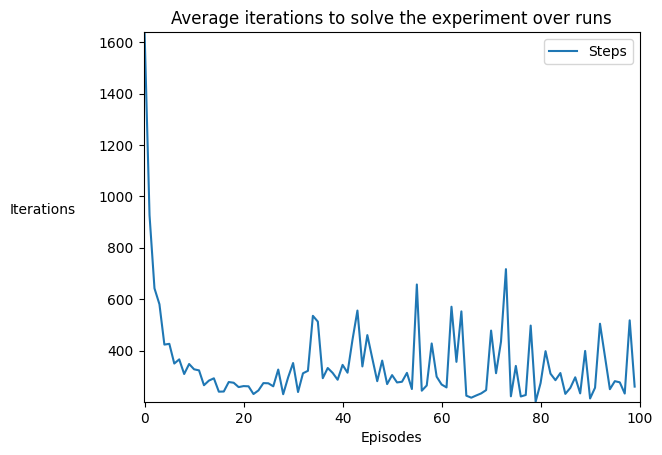

The Minimum number of iterations used to solve the experiment were: 3286

The Maximum number of iterations used to solve the experiment were: 122



In [8]:
steps_average = np.mean(np.array(all_steps), axis=0)
plt.plot(steps_average, label = 'Steps')
plt.xlabel("Episodes")
plt.ylabel("Iterations",rotation=0, labelpad=40)
plt.xlim(-0.2, num_episodes)
plt.ylim(steps_average.min(), steps_average.max())
plt.title("Average iterations to solve the experiment over runs")
plt.legend()
plt.show()
print("The Minimum number of iterations used to solve the experiment were: {0}\n".format(np.array(all_steps).max()))
print("The Maximum number of iterations used to solve the experiment were: {0}\n".format(np.array(all_steps).min()))

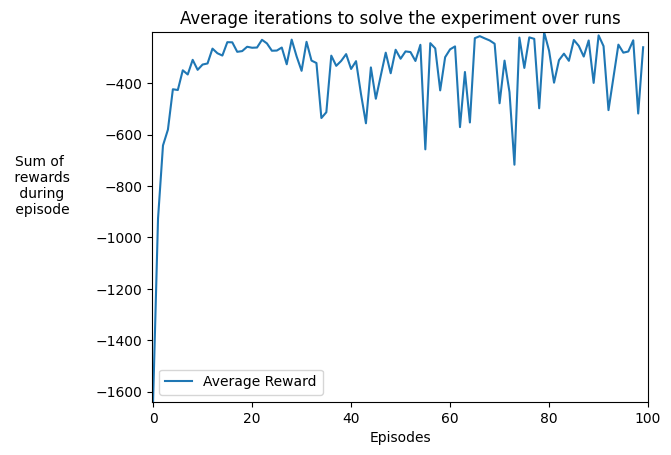

The best reward obtained solving the experiment was: -122.0

The Wordt reward obtained solving the experiment was: -3286.0



In [9]:
rewards_average = np.mean(all_rewards, axis=0)
plt.plot(rewards_average, label = 'Average Reward')
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode" ,rotation=0, labelpad=40)
plt.xlim(-0.2, num_episodes)
plt.ylim(rewards_average.min(), rewards_average.max())
plt.title("Average iterations to solve the experiment over runs")
plt.legend()
plt.show()
print("The best reward obtained solving the experiment was: {0}\n".format(np.array(all_rewards).max()))
print("The Wordt reward obtained solving the experiment was: {0}\n".format(np.array(all_rewards).min()))

## Using the last trained Agent 

This lines shows in a video the performance of the last trained agent and save a video with the results.

In [10]:
# Test Sarsa Agent 
num_runs = 1
num_episodes = 1000

# Environment
env_to_wrap = gym.make('MountainCar-v0', render_mode='rgb_array', max_episode_steps=1500)
env = RecordVideo(env_to_wrap, "./videos/mountainCar", episode_trigger=lambda episode_id: True)


# Number of runs are the times the experiment will start again (a.k.a episode)
for n_runs in tqdm(range(num_runs)):
    
    # Resets environment
    observation, info = env.reset()
    # Generate last state and action in the agent
    last_action = agent.agent_start(observation)
        
    # Times the environment will start again without resetting the agent
    for t in tqdm(range(num_episodes)):

        # Take a step with the environment
        observation, reward, terminated, truncated, info = env.step(last_action)
        done = terminated or truncated

        # If the goal has been reached stop
        if done:
            # Last step with the agent
            agent.agent_end(reward)
            break

        else:
            # Take a step with the agent
            last_action = agent.agent_step(reward, observation)


env.close()
env_to_wrap.close()

print("Episode finished after {} timesteps".format(t+1))

100%|██████████| 1/1 [00:09<00:00,  9.12s/it]


Episode finished after 222 timesteps


## Plotting the Action-Values of the agent

This final plot aims to show the action-values learned by the agent with Sarsa. The action value for a given state was calculated using: -$max_a\hat{q}(s, a, w)$

In [11]:
# Resolution
values = 500
# Vector of positions
pos_vals = np.linspace(-1.2, 0.5, num = values)
# Vector of velocities
vel_vals = np.linspace(-0.07, 0.07, num = values)

# Z grid values
av_grid = np.zeros((values, values))

# Compute Action-values for each pos - vel pair
for ix in range(len(pos_vals)):
    for iy in range(len(vel_vals)):
        av_grid[ix][iy] = -1 * agent.return_action_value([pos_vals[ix], vel_vals[iy]])

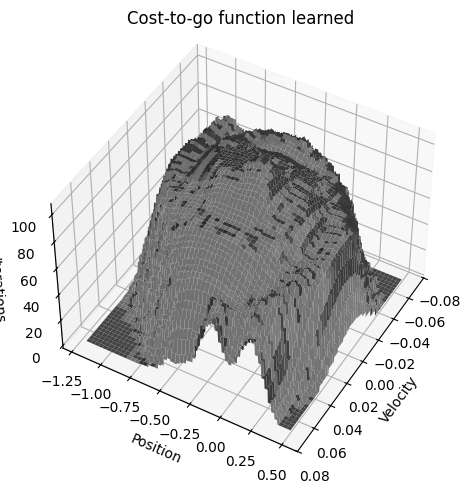

In [12]:
# Plot the 3D surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
Px, Vy = np.meshgrid(pos_vals, vel_vals)
ax.plot_surface(Vy, Px, av_grid, color = 'gray')
ax.set_title("Cost-to-go function learned", y = 1.1)
ax.set_xlabel('Velocity')
ax.set_ylabel('Position')
ax.set_zlabel('Iterations')
ax.view_init(45, azim=30)
plt.tight_layout()
plt.show()